## Southern Ocean decadal variability

Assess the decadal variability of water mass transformation in the Southern Ocean, and relate it to changes in the overturning circulation.

In [31]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
import pandas as pd
%matplotlib inline

### Load the data

In [2]:
rootdir = '/local/projects/so_decadal_variability/'
grid_name = 'en4'
ocean_name = 'en4'
flux_name = 'erai'
ocean_times = '197901-201812'
flux_times = '1979-2018'
time_bnds = [0,480]
# Grid
vol4d = xr.open_dataset(rootdir+'grid/SO_grid_vol4d_'+grid_name+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
garea = xr.open_dataset(rootdir+'grid/SO_grid_garea_'+grid_name+'.nc')
grid = xr.merge([vol4d,garea])
dz = grid.depth_bnds.diff(dim='bnds').squeeze(dim='bnds',drop=True)
# Hydrography
ct = xr.open_dataset(rootdir+'ocean/SO_ocean_ct_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
sa = xr.open_dataset(rootdir+'ocean/SO_ocean_sa_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
gamman = xr.open_dataset(rootdir+'ocean/SO_ocean_gamman_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
alpha = xr.open_dataset(rootdir+'ocean/SO_ocean_alpha_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
beta = xr.open_dataset(rootdir+'ocean/SO_ocean_beta_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
rho = xr.open_dataset(rootdir+'ocean/SO_ocean_rho_'+ocean_name+'_'+ocean_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1]))
# Merge
ocean = xr.merge([ct,sa,gamman,alpha,beta,rho])
ocean['gamman']+=1000 # Make gamman a proper density
# Heat and freshwater flux
Q = -xr.open_dataset(rootdir+'flux/SO_flux_ht_'+flux_name+'_'+grid_name+'_'+flux_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1])).assign_coords(time=grid.time)
Qsw = -xr.open_dataset(rootdir+'flux/SO_flux_sr_'+flux_name+'_'+grid_name+'_'+flux_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1])).assign_coords(time=grid.time)
FW = xr.open_dataset(rootdir+'flux/SO_flux_fw_'+flux_name+'_'+grid_name+'_'+flux_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1])).assign_coords(time=grid.time)

## Depth penetration of shortwave radiation

Use empirical exponential decay function of Paulson and Simpson (1977)
$$ F_{PS77}(z) = R\ e^{-\frac{z}{h_1}}+(1-R)e^{-\frac{z}{h_2}} $$
where $R = 0.58$, $h_1 = 0.35m$, and $h_2 = 23m$.

In [3]:
R = 0.58
h1 = 0.35
h2 = 23

# Calculate in 1D
depth_i_vals = np.append(grid.depth_bnds.isel(bnds=0), grid.depth_bnds.isel(bnds=1)[-1])
depth_i = xr.DataArray(depth_i_vals,coords={'depth_i':depth_i_vals},dims={'depth_i'})
Fps77 = R*np.exp(-depth_i/h1)+(1-R)*np.exp(-depth_i/h2)

# Now get a 3D shortwave field
Qsw3d = Qsw.sr*Fps77
# and take the divergence
# (note that for taking the derivative, 'depth' must be positive upward, so reverse the sign)
# (subsequently, reverse the sign so that it is consistent with the other variables)
dQsw3d = -Qsw3d.diff('depth_i').rename({'depth_i':'depth'}).assign_coords(depth=grid.depth)/dz

## b-factor

From Jacket and McDougall (2005):
$$ b = \frac{|\nabla \gamma^n|}{|\nabla \rho_l|} $$

From Groeskamp et al. (2018):
$$ \nabla \rho_l = \rho (-\alpha\nabla \Theta + \beta \nabla S_A)$$
where $\rho$ is _in situ_ density.

In [4]:
def calc_b(T,S,rho,alpha,beta,gamma):
    # Calculate gradients in T, S and gamma
    # T
    gradx_T = T.differentiate('lon')
    grady_T = T.differentiate('lat')
    gradz_T = T.differentiate('depth')
    # S
    gradx_S = S.differentiate('lon')
    grady_S = S.differentiate('lat')
    gradz_S = S.differentiate('depth')
    # Locally referenced potential density
    gradx_r = rho*(-alpha*gradx_T + beta*gradx_S)
    grady_r = rho*(-alpha*grady_T + beta*grady_S)
    gradz_r = rho*(-alpha*gradz_T + beta*gradz_S)
    # gamma
    gradx_g = gamma.differentiate('lon')
    grady_g = gamma.differentiate('lat')
    gradz_g = gamma.differentiate('depth')

    # Calculate the absolute magnitudes
    absgradx_r = xr.ufuncs.sqrt(xr.ufuncs.square(gradx_r)+xr.ufuncs.square(grady_r)+xr.ufuncs.square(gradz_r))
    absgradx_g = xr.ufuncs.sqrt(xr.ufuncs.square(gradx_g)+xr.ufuncs.square(grady_g)+xr.ufuncs.square(gradz_g))
    
    # Calculate ratio
    b = absgradx_g/absgradx_r
    
    return b

In [5]:
# Calculate b
b = calc_b(ocean.ct,ocean.sa,ocean.rho,ocean.alpha,ocean.beta,ocean.gamman)

## Water mass transformation calculation

From Groeskamp and Iudicone (2018), transformation across a $\gamma^n$ surface is given by:
$$ G(\gamma^n) = \frac{\partial}{\partial \gamma^n}\iiint_{\hat{\gamma^n}\leq\gamma^n} \hat{\gamma^n}\ b\ F\ dV $$

We utilise the discrete volume formulation derived in Groeskamp et al. (2019), Appendix 7.5, Eq. 48  
TO FILL IN EQUATION

The surface density flux, $F$, is given by:
$$ F = \big[-(E+P+R)S_A\beta + \frac{\alpha}{C_p}(Q_{lw}+Q_{lh}+Q_{sh})\big]\delta(z-\eta) + \frac{\alpha}{C_p}\nabla \cdot Q_{sw} F(z) $$
where $F(z)$ describes the vertical penetration of incoming shortwave radiation. Freshwater fluxes are _positive_ into the ocean, heat fluxes are _positive_ into the atmosphere.

In [6]:
def calc_F(FW,Q,Qsw,S,alpha,beta,Cp=4200):
    
    Fheat = (alpha/Cp)*Q + (alpha/Cp)*Qsw
    Ffw = -FW*S*beta
    F = Fheat+Ffw
    
    F.name = 'F'
    Fheat.name = 'Fheat'
    Ffw.name = 'Ffw'
    
    return F, Fheat, Ffw

In [7]:
# Create a 3D mask with 1/dz in the surface and zero elsewhere
mask = xr.zeros_like(ocean.ct)
mask.loc[dict(depth=ocean.depth[0])]=1/dz[0]
# Calculate the specific heat capacity of water

# Calculate density flux
F,Fheat,Ffw = calc_F(FW.fw*mask,Q.ht*mask,dQsw3d,ocean.sa,ocean.alpha,ocean.beta)

Plot the density change due to heat and freshwater forcing

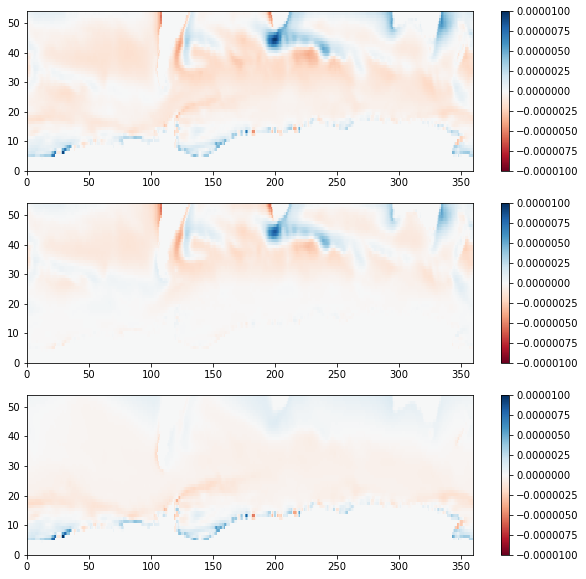

In [8]:
fig,ax = plt.subplots(figsize=(10,10),nrows=3)
im=ax[0].pcolormesh((F*dz).sum('depth').mean('time'),cmap='RdBu',vmin=-1E-5,vmax=1E-5)
plt.colorbar(im,ax=ax[0])
im=ax[1].pcolormesh((Fheat*dz).sum('depth').mean('time'),cmap='RdBu',vmin=-1E-5,vmax=1E-5)
plt.colorbar(im,ax=ax[1])
im=ax[2].pcolormesh((Ffw*dz).sum('depth').mean('time'),cmap='RdBu',vmin=-1E-5,vmax=1E-5)
plt.colorbar(im,ax=ax[2])

In [9]:
# Discrete volume calculation derived in Appendix 7.5 of Groeskamp et al (2018)
def calc_G(F,gamman,b,V,gn_edges):
    gFbV = gamman*b*F*V
    nanmask=np.isnan(gFbV)
    G = histogram(gamman.where(~nanmask),bins=[gn_edges],weights=gFbV.where(~nanmask),dim=['lat','lon','depth'])/np.diff(gn_edges)
    return G

In [10]:
# Calculate G
gn_edges = np.arange(1026,1028.5,0.1)
Gheat = calc_G(Fheat,ocean.gamman,xr.ones_like(b),vol4d.vol4d,gn_edges)
Gfw = calc_G(Ffw,ocean.gamman,xr.ones_like(b),vol4d.vol4d,gn_edges)
G = calc_G(F,ocean.gamman,xr.ones_like(b),vol4d.vol4d,gn_edges)

Text(0,0.5,'water mass transformation (10^9 kg s^-1)')

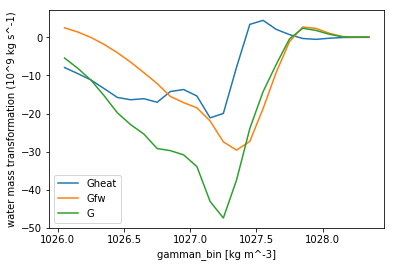

In [11]:
(Gheat*1E-9).mean('time').plot(label='Gheat')
(Gfw*1E-9).mean('time').plot(label='Gfw')
(G*1E-9).mean('time').plot(label='G')
plt.legend()
plt.ylabel('water mass transformation (10^9 kg s^-1)')

Take annual means and remove time-mean signal

In [12]:
def calc_annualanom(da):
    annual = da.coarsen(time=12,boundary='trim').mean()
    mean = da.mean('time')*xr.ones_like(annual)
    annualanom = annual-mean
    return annualanom

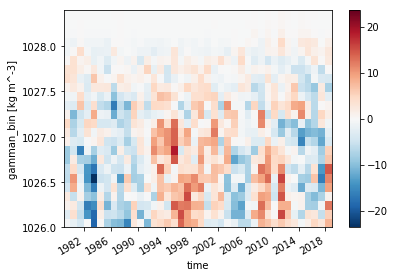

In [13]:
Gannualanom = calc_annualanom(G)
(Gannualanom*1E-9).transpose().plot()

## Calculate dV/dt

In [14]:
mass = ocean.rho*vol4d.vol4d
nanmask=np.isnan(ocean.gamman)
V = histogram(ocean.gamman.where(~nanmask),bins=[gn_edges],weights=mass.where(~nanmask),dim=['lat','lon','depth']).transpose()
V = V.sortby('gamman_bin',ascending=False).cumsum('gamman_bin').sortby('gamman_bin',ascending=True)
dVdt = V.diff('time')/V.time.diff('time').values.astype('timedelta64[s]').astype('float')

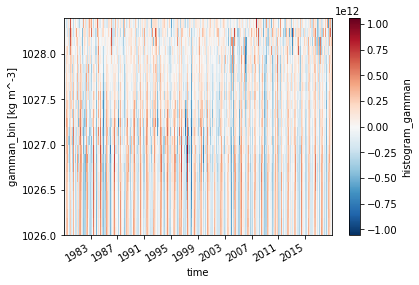

In [15]:
dVdt.plot()

In [56]:
# Deal with the time offset
timenew = V.time[:-1]+(V.time.shift({'time':-1})-V.time[:-1])/4 # Note that this is set to 4 not for alignment but so that each is in a separate month
dVdt = dVdt.assign_coords(time=timenew)
Gint = G.interp(time=timenew).assign_coords(time=timenew)

In [59]:
Gint_new = Gint.assign_coords(time=pd.to_datetime(Gint.time.values).month)
dVdt_new = dVdt.assign_coords(time=pd.to_datetime(dVdt.time.values).month)

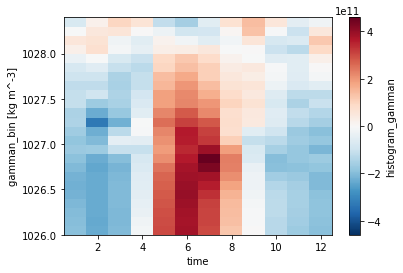

In [62]:
dVdt_new.groupby('time').mean().plot()

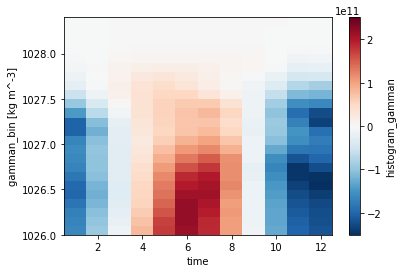

In [64]:
Gint_new.groupby('time').mean().transpose().plot()

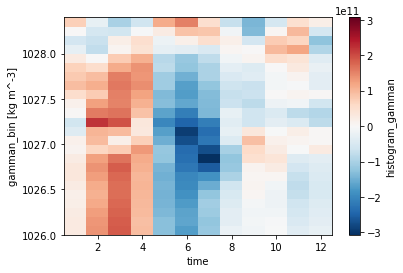

In [65]:
(Gint_new.groupby('time').mean().transpose()-dVdt_new.groupby('time').mean()).plot()